* In a [previous notebook](https://laurentperrinet.github.io/sciblog/posts/2017-03-14-reproducing-olshausens-classical-sparsenet.html), we tried to reproduce the learning strategy specified in the framework of the [SparseNet algorithm from Bruno Olshausen](http://redwood.berkeley.edu/bruno/sparsenet/). It allows to efficiently code natural image patches by constraining the code to be sparse.

* However, the dictionaries are qualitatively not the same as the one from the original paper, and this is certainly due to the lack of control in the competition during the learning phase.
* Herein, we re-implement the cooperation mechanism in the dictionary learning routine - this will be then proposed to the main code.

This is joint work with [Victor Boutin](http://invibe.net/LaurentPerrinet/VictorBoutin).

<!-- TEASER_END -->

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format='svg'
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import pandas as pd
import seaborn as sns
%load_ext autoreload
%autoreload 2

In [2]:
from shl_scripts import SHL
DEBUG_DOWNSCALE, verbose = 1, 0
database = 'database/'

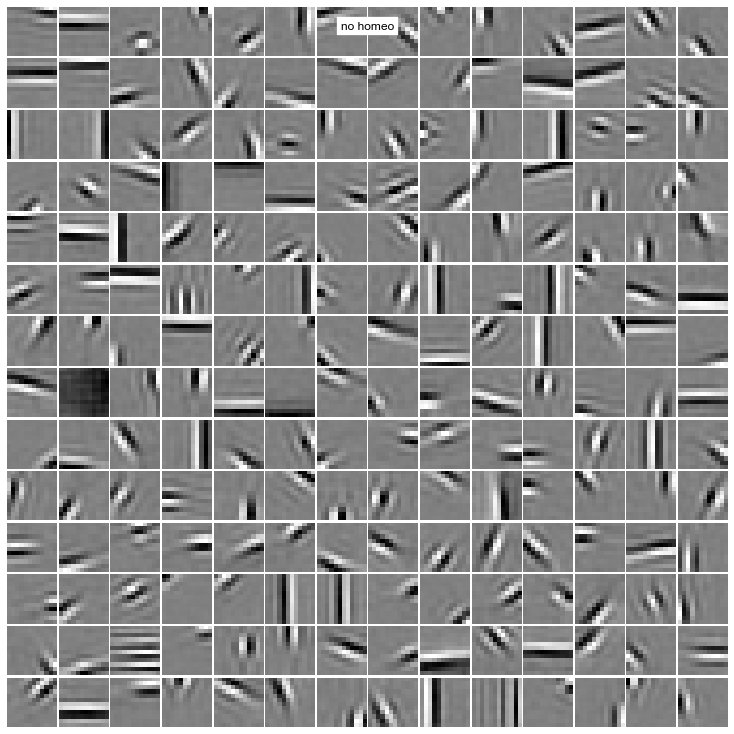

In [3]:
shl = SHL(database=database, DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, verbose=verbose, eta_homeo=0.)
matname = 'no homeo'
dico = shl.learn_dico(matname=matname)
fig, ax = dico.show_dico(title=matname)
fig.show()

## a quick diagnostic

An assumption in the existing code is the way that the norm of the filters is controlled. Here, sklearn simply assumes that $ || V_k ||_2 = 1$,  $\forall k$ (with $0 <= k < n_{components}$). This may be a problem as a dictionary element with a high variance may be more likely to be selected again, and therefore that the learning will concentrate only on a small sub-set of elements. 

In [4]:
data = shl.get_data()
print(shl.max_patches)
shl.transform_algorithm='mp'
shl.l0_sparseness=int(shl.n_dictionary/10)
code = dico.transform(data)

1024


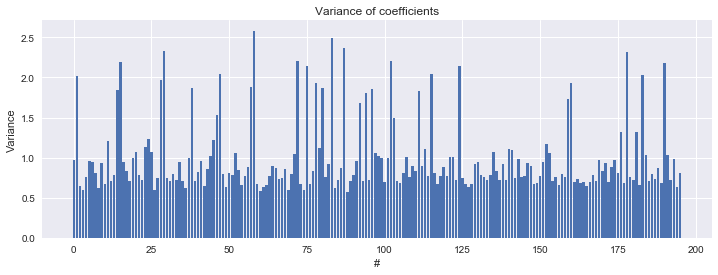

In [5]:
n_dictionary, n_samples = code.shape
Z = np.mean(code**2)
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)
ax.bar(np.arange(shl.n_dictionary), np.mean(code**2/Z, axis=0))#, yerr=np.std(code**2/Z, axis=0))
ax.set_title('Variance of coefficients')
ax.set_ylabel('Variance')
ax.set_xlabel('#')
ax.axis('tight')
fig.show()

Worst, this distribution has heavy tails, showing that a small sub-set dominate: this is best shown by showing the correding histogram oif mean variance values:

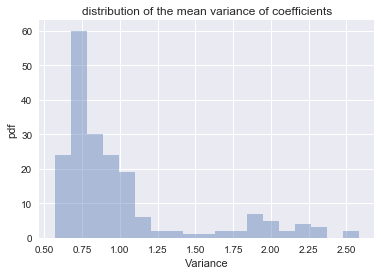

In [6]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
data = pd.DataFrame(np.mean(code**2, axis=0)/np.mean(code**2), columns=['Variance'])
with sns.axes_style("white"):
    ax = sns.distplot(data['Variance'], kde=False)# kde_kws={'clip':(0., 5.)})
ax.set_title('distribution of the mean variance of coefficients')
ax.set_ylabel('pdf')
fig.show()

A strategy used by Olshausen in it's original paper is to include a gain vector which will be used during the learning to control the norm of the dictionary elements. In turn, this will control how these elements learn and allow for a more equilibrated learning. Let's try to implement thatin sklearn's code.

## great, let's try that new version  of the algorithm




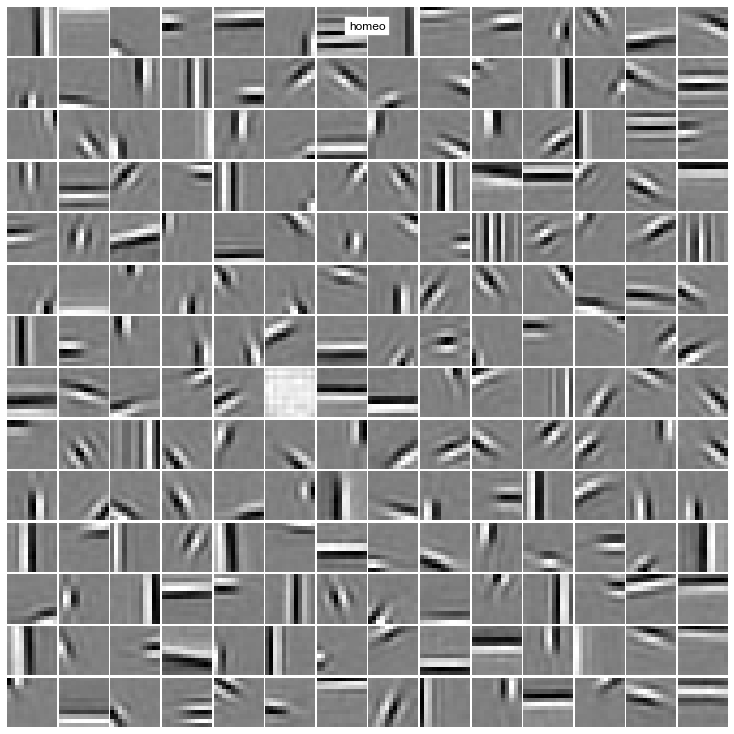

In [7]:
from shl_scripts import SHL
matname = 'homeo'
shl = SHL(database=database, DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, verbose=verbose, eta_homeo=0.1)
dico = shl.learn_dico(matname=matname)
fig, ax = dico.show_dico(title=matname)
fig.show()

This dictionary looks better and similar to that of Olshausen.

Let's now check the mean variance of the different components (remember it is the same coding algorithm):

In [8]:
data = shl.get_data()
code = dico.transform(data, algorithm='mp', l0_sparseness=shl.l0_sparseness)

In [9]:
code.shape

(204800, 196)

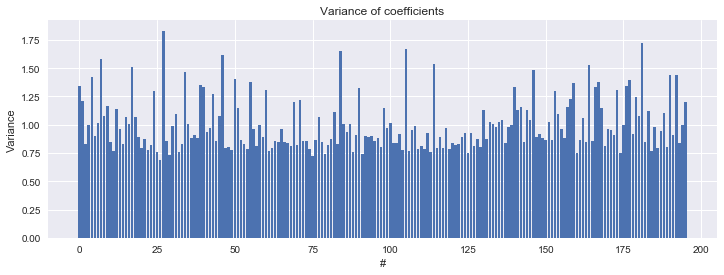

In [10]:
n_dictionary, n_samples = code.shape
Z = np.mean(code**2)
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)
ax.bar(np.arange(shl.n_dictionary), np.mean(code**2/Z, axis=0))
ax.set_title('Variance of coefficients')
ax.set_ylabel('Variance')
ax.set_xlabel('#')
ax.axis('tight')
fig.show()

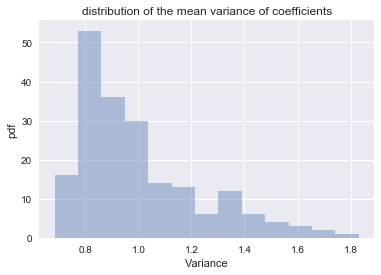

In [11]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
data = pd.DataFrame(np.mean(code**2, axis=0)/np.mean(code**2), columns=['Variance'])
with sns.axes_style("white"):
    ax = sns.distplot(data['Variance'], kde=False)# kde_kws={'clip':(0., 5.)})
ax.set_title('distribution of the mean variance of coefficients')
ax.set_ylabel('pdf')
fig.show()

## conclusion

When introducing the homeostasis from Olshausen in ``sklearn``'s dictionary learning, the filters converge faster to a set of edge filters. Moreover, the distribution of the variance of the coefficients is now unimodal and more uniform. However, there seems still to be a problem in this equilibrium state.

First, in [another notebook](https://laurentperrinet.github.io/sciblog/posts/2017-03-17-extending-olshausens-classical-sparsenet.html), we will test the role for the different parameters in this homeostasis mechanism.


In [an extension](https://laurentperrinet.github.io/sciblog/posts/2017-03-17-extending-olshausens-classical-sparsenet.html), we will study how homeostasis (cooperation) may be an essential ingredient to this algorithm working on a winner-take-all basis (competition). This extension has been published as Perrinet, Neural Computation (2010) (see  http://invibe.net/LaurentPerrinet/Publications/Perrinet10shl ).

